<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 8.4: Sentiment Analysis
INSTRUCTIONS:
- Run the cells
- Observe and understand the results
- Answer the questions

Based on the video tutorial **Text Classification with Machine Learning,SpaCy and Scikit(Sentiment Analysis)** by **Jesse E. Agbe (JCharis)**.

## Data Source: UCI
### UCI - Machine Learning Repository
- Center for Machine Learning and Intelligent Systems

The [**UCI Machine Learning Repository**](http://archive.ics.uci.edu/ml/about.html) is a collection of databases, domain theories, and data generators that are used by the machine learning community for the empirical analysis of machine learning algorithms.

### Dataset
- [Sentiment Labelled Sentences Data Set](http://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

### Abstract
The dataset contains sentences labelled with positive or negative sentiment.

- Data Set Characteristics: Text
- Number of Instances: 3000
- Area: N/A
- Attribute Characteristics: N/A
- Number of Attributes: N/A
- Date Donated: 2015-05-30
- Associated Tasks: Classification
- Missing Values? N/A
- Number of Web Hits: 102584

### Source
Dimitrios Kotzias dkotzias '@' ics.uci.edu

### Data Set Information
This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015

Please cite the paper if you want to use it :)

It contains sentences labelled with positive or negative sentiment.

### Format
sentence &lt;tab&gt; score &lt;newline&gt;

### Details
Score is either 1 (for positive) or 0 (for negative)

The sentences come from three different websites/fields:
- imdb.com
- amazon.com
- yelp.com

For each website, there exist **500 positive** and **500 negative** sentences. Those were selected randomly for larger datasets of reviews.

We attempted to select sentences that have a clearly positive or negative connotaton, the goal was for no neutral sentences to be selected.

For the full datasets look:

- **imdb**: Maas et. al., 2011 _Learning word vectors for sentiment analysis_
- **amazon**: McAuley et. al., 2013 _Hidden factors and hidden topics: Understanding rating dimensions with review text_
- **yelp**: [Yelp dataset challenge](http://www.yelp.com/dataset_challenge)


### Attribute Information
The attributes are text sentences, extracted from reviews of products, movies, and restaurants

### Relevant Papers
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

### Citation Request
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

## Import libraries

In [232]:
## Import Libraries
import pandas as pd

import regex as re
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

## Load data

Load Yelp, Amazon and Imdb Data.

Hint: Source is separated by tabs and has no headers.

In [233]:
# load data
df_yelp = pd.read_csv('../../DATA/yelp_labelled.txt', header = None, sep = '\t')
df_imdb = pd.read_csv('../../DATA/imdb_labelled_fixed.txt', header = None, sep = '\t') # New file without double quotes
df_amazon = pd.read_csv('../../DATA/amazon_cells_labelled.txt', header = None, sep = '\t')
dfs = {'yelp': df_yelp, 'imdb': df_imdb, 'amazon': df_amazon}

In [234]:
df_yelp.head()

,0,1
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [235]:
dfs

{'yelp':                                                      0  1
 0                             Wow... Loved this place.  1
 1                                   Crust is not good.  0
 2            Not tasty and the texture was just nasty.  0
 3    Stopped by during the late May bank holiday of...  1
 4    The selection on the menu was great and so wer...  1
 ..                                                 ... ..
 995  I think food should have flavor and texture an...  0
 996                           Appetite instantly gone.  0
 997  Overall I was not impressed and would not go b...  0
 998  The whole experience was underwhelming, and I ...  0
 999  Then, as if I hadn't wasted enough of my life ...  0
 
 [1000 rows x 2 columns],
 'imdb':                                                      0  1
 0    A very, very, very slow-moving, aimless movie ...  0
 1    Not sure who was more lost - the flat characte...  0
 2    Attempting artiness with black & white and cle...  0
 3         V

## Inspect the data

Check your datasets.

In [236]:
# - assign column names
# - add the data source
# - check the data

for ds in dfs.keys():
    print('Dataset: %s [%d row(s) x %d col(s)]' % (ds, dfs[ds].shape[0], dfs[ds].shape[1]))
    dfs[ds].columns = ['text', 'sentiment']
    dfs[ds]['source'] = ds
    print(dfs[ds].head())
    print('-' * 75)

Dataset: yelp [1000 row(s) x 2 col(s)]
                                                text  sentiment source
0                           Wow... Loved this place.          1   yelp
1                                 Crust is not good.          0   yelp
2          Not tasty and the texture was just nasty.          0   yelp
3  Stopped by during the late May bank holiday of...          1   yelp
4  The selection on the menu was great and so wer...          1   yelp
---------------------------------------------------------------------------
Dataset: imdb [1000 row(s) x 2 col(s)]
                                                text  sentiment source
0  A very, very, very slow-moving, aimless movie ...          0   imdb
1  Not sure who was more lost - the flat characte...          0   imdb
2  Attempting artiness with black & white and cle...          0   imdb
3       Very little music or anything to speak of.            0   imdb
4  The best scene in the movie was when Gerardo i...          1  

In [237]:
dfs

{'yelp':                                                   text  sentiment source
 0                             Wow... Loved this place.          1   yelp
 1                                   Crust is not good.          0   yelp
 2            Not tasty and the texture was just nasty.          0   yelp
 3    Stopped by during the late May bank holiday of...          1   yelp
 4    The selection on the menu was great and so wer...          1   yelp
 ..                                                 ...        ...    ...
 995  I think food should have flavor and texture an...          0   yelp
 996                           Appetite instantly gone.          0   yelp
 997  Overall I was not impressed and would not go b...          0   yelp
 998  The whole experience was underwhelming, and I ...          0   yelp
 999  Then, as if I hadn't wasted enough of my life ...          0   yelp
 
 [1000 rows x 3 columns],
 'imdb':                                                   text  sentiment s

## Merge the data

Merge all three datasets.

In [238]:
df = pd.concat(dfs.values(), ignore_index = True)

# or just
# df = pd.concat(dfs, ignore_index = True)

In [239]:
df.head()

,text,sentiment,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


In [240]:
print('Dataset: %s [%d row(s) x %d col(s)]\n' % ('All', df.shape[0], df.shape[1]))
print(df.info())
print(df.sample(10))
print('-' * 75)

Dataset: All [3000 row(s) x 3 col(s)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3000 non-null   object
 1   sentiment  3000 non-null   int64 
 2   source     3000 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB
None
                                                   text  sentiment  source
1412  Not too screamy not to masculine but just righ...          1    imdb
906   After the disappointing dinner we went elsewhe...          0    yelp
813                                     It was packed!!          0    yelp
2105  Pros:-Good camera - very nice pictures , also ...          1  amazon
1652  Don't be afraid of subtitles........ its worth...          1    imdb
1132  This was a poor remake of My Best Friends Wedd...          0    imdb
1993                It looked like a wonderful story.            1    imdb
2208

In [241]:
df.shape

(3000, 3)

## Export the data

Export merged datasets to as csv file.

In [242]:
df.to_csv('../../DATA/sentiments.csv', index = None)

## Prepare the stage
- Load spaCy

Install trained English model for spaCy via conda prompt `python -m spacy download en_core_web_sm`

Alternatively, try `conda install -c conda-forge spacy-model-en_core_web_sm`

In [243]:
nlp = spacy.load('en_core_web_sm')

# Alternatively, ...
# import en_core_web_sm
# nlp = en_core_web_sm.load()

## Prepare the text
All the text handling and preparation concerned with the changes and modifications from the raw source text to a format that will be used for the actual processing, things like:
- handle encoding
- handle extraneous and international characters
- handle symbols
- handle metadata and embedded information
- handle repetitions (such multiple spaces or newlines)

Clean text.

In [244]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)

    return text

In [245]:
df['text'] = df['text'].apply(clean_text)

## Work the text
Concern with the meaning and the substance of the content to extract actual information.

Hint: Use techniques learned in previous labs. Remove StopWords, Punctuation, Lemmatize etc.

In [246]:
def convert_text(text):
    '''
    Function to remove stopWords, punctuations and digits 
    as well as lemmatize non-named entity words
    '''
    sent = nlp(text)
    ents = {x.text: x for x in sent.ents}
    tokens = []
    
    for w in sent:
        if w.is_stop or w.is_punct or w.is_digit: # remove stopWords, punctuations, digits
            continue
        if w.text in ents: # if token is in named entities dict
            tokens.append(w.text) # append named entities unchanged
        else:
            tokens.append(w.lemma_.lower()) # lemmatize all other words
    text = ' '.join(tokens)

    return text

Note! The `continue` statement in Python is used to skip the remaining code inside a loop for the current iteration only

Dissect this function further

In [288]:
text = 'Apple is looking at buying U.K. startup for $1 billion.'

In [289]:
sent = nlp(text)
sent

Apple is looking at buying U.K. startup for $1 billion.

In [ ]:
[token.text for token in sent]

[Apple, is, looking, at, buying, U.K., startup, for, $, 1, billion, .]

In [ ]:
[token.text for token in sent]

[Apple, is, looking, at, buying, U.K., startup, for, $, 1, billion, .]

In [292]:
# named entities
sent.ents

(Apple, U.K., $1 billion)

In [252]:
ents = {x.text: x for x in sent.ents}
ents

{'Apple': Apple, 'U.K.': U.K., '$1 billion': $1 billion}

In [253]:
%%time
df['short'] = df['text'].apply(convert_text)

Wall time: 18 s


In [254]:
df.sample(10)

,text,sentiment,source,short
826,Food quality has been horrible.,0,yelp,food quality horrible
2564,Yet Plantronincs continues to use the same fla...,0,amazon,plantronincs continue use flawed charger design
1,Crust is not good.,0,yelp,crust good
2985,There was so much hype over this phone that I ...,0,amazon,hype phone assume good mistake
2262,Works great.,1,amazon,work great
706,The atmosphere here is fun.,1,yelp,atmosphere fun
464,The inside is really quite nice and very clean.,1,yelp,inside nice clean
391,I will continue to come here on ladies night a...,1,yelp,continue come lady night andddd date night hig...
491,The menu had so much good stuff on it i could ...,1,yelp,menu good stuff decide
294,I didn't know pulled pork could be soooo delic...,1,yelp,know pull pork soooo delicious


In [255]:
df.shape

(3000, 4)

## Modelling

In [256]:
# helper function to show results and charts
def show_summary_report(actual, prediction, probabilities):

    if isinstance(actual, pd.Series):
        actual = actual.values.astype(int)
    prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, probabilities)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, probabilities)
    average_precision = average_precision_score(actual, probabilities)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities)
    roc_auc = auc(fpr, tpr)


    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_)

In [257]:
# Features and Labels
X = df['short']
y = df['sentiment']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [258]:
X_train.shape, X_test.shape

((2400,), (600,))

## Use Bag-of-Words

In [259]:
# create a matrix of word counts from the text
counts = CountVectorizer(ngram_range=(1,1))
counts

CountVectorizer()

In [260]:
# do the actual counting
A = counts.fit_transform(X_train)

In [261]:
A

<2400x3571 sparse matrix of type '<class 'numpy.int64'>'
	with 12259 stored elements in Compressed Sparse Row format>

In [262]:
counts.get_feature_names()

['00',
 '10',
 '11',
 '13',
 '15',
 '15pm',
 '17',
 '20th',
 '2mp',
 '30',
 '3o',
 '42',
 '44',
 '4s',
 '4ths',
 '50',
 '70s',
 '85',
 '99',
 'aailiyah',
 'abandon',
 'abhor',
 'ability',
 'able',
 'abound',
 'abroad',
 'absolute',
 'absolutel',
 'absolutely',
 'absolutley',
 'abstruse',
 'abysmal',
 'ac',
 'academy',
 'accent',
 'accept',
 'acceptable',
 'access',
 'accessable',
 'accessible',
 'accessory',
 'accessoryone',
 'accidentally',
 'acclaim',
 'accomodate',
 'accompanied',
 'accord',
 'accordingly',
 'accurate',
 'accurately',
 'accuse',
 'ache',
 'achievement',
 'achille',
 'ackerman',
 'acknowledge',
 'act',
 'acting',
 'action',
 'activate',
 'activesync',
 'actor',
 'actors',
 'actress',
 'actual',
 'actually',
 'ad',
 'adams',
 'adaptation',
 'adapter',
 'add',
 'addition',
 'additional',
 'address',
 'adhesive',
 'admin',
 'admiration',
 'admit',
 'adorable',
 'adrift',
 'adventure',
 'advertise',
 'advise',
 'aerial',
 'affleck',
 'affordable',
 'afraid',
 'africa',
 

In [263]:
len(counts.get_feature_names())

3571

In [264]:
# What does A look like after BOW?
pd.DataFrame(A.todense(), columns=counts.get_feature_names()) # .todense() required

,00,10,11,13,15,15pm,17,20th,2mp,30,...,yucky,yukon,yum,yummy,yun,z500a,zero,zillion,zombie,zombiez
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Play with ngram_range**

In [265]:
# create a matrix of word counts from the text
counts2 = CountVectorizer(ngram_range=(2,3))
counts2

CountVectorizer(ngram_range=(2, 3))

In [266]:
# do the actual counting
A2 = counts2.fit_transform(X_train)

In [267]:
# What does A look like after BOW?
pd.DataFrame(A2.todense(), columns=counts2.get_feature_names()) # .todense() required

,10 10,10 grade,10 grade note,10 score,10 score plot,10 series,10 series work,10 setting,10 setting 10,11 99,...,yun fat better,z500a pretty,z500a pretty happy,zero star,zero star zero,zillion time,zillion time away,zombie movie,zombiez hellish,zombiez hellish trinity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [268]:
# Subset df to check out some feature names
df[df['short'].str.contains('zero star')]

,text,sentiment,source,short
235,"If it were possible to give them zero stars, t...",0,yelp,possible zero star
257,I as well would've given godfathers zero stars...,0,yelp,give godfather zero star possible
536,If there were zero stars I would give it zero ...,0,yelp,zero star zero star
2546,Worst software ever used.... If I could give t...,0,amazon,bad software zero star


In [269]:
# to matrix
A.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [270]:
A.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [271]:
A.toarray().shape

(2400, 3571)

In [272]:
X_train

642                 waiter attentive friendly informative
700                      chip come dripping grease edible
226                                  unbelievable bargain
1697    mediocre miserable hollow laughable predictabl...
1010                                  baby owl adorable  
                              ...                        
1638    film excellently produce top rating typical sc...
1095    manna heaven terrific film predictable unpredi...
1130    chemistry ben affleck sandra bullock film unde...
1294    favourite director talented director history c...
860         place pretty good nice little vibe restaurant
Name: short, Length: 2400, dtype: object

In [273]:
# create a classifier using SVC
classifier = SVC(kernel='linear', probability=True)

In [274]:
# train the classifier with the training data
classifier.fit(A, y_train)

SVC(kernel='linear', probability=True)

In [275]:
# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = counts.transform(X_test)

In [276]:
# make predictions based on the test data
predictions = classifier.predict(B)

# store probabilities of predictions being 1
probabilities = classifier.predict_proba(B)[:, 1]

In [277]:
predictions[:5]

array([0, 1, 0, 0, 1], dtype=int64)

In [278]:
len(predictions)

600

In [279]:
probabilities[:5]

array([0.09567641, 0.92417915, 0.31334745, 0.26238075, 0.51083113])

In [280]:
len(probabilities)

600

In [281]:
X_test[:5]

1801                                         avoid cost  
1190    Garbo show right bat talent carry silent era w...
1817                      leave theater want dance star  
251                                   privileged work eat
2505    sound quality device unacceptable quiet area hear
Name: short, dtype: object

In [282]:
y_test[:5]

1801    0
1190    1
1817    1
251     0
2505    0
Name: sentiment, dtype: int64

In [283]:
# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.7850


## Repeat using TF-IDF
TF-IDF = Term Frequency - Inverse Document Frequency

In [284]:
# create a matrix of word counts from the text
# use TF-IDF
tfidf = TfidfVectorizer()
# do the actual counting
A = tfidf.fit_transform(X_train)

# train the classifier with the training data
classifier.fit(A, y_train)

# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = tfidf.transform(X_test)

# make predictions based on the test data
predictions = classifier.predict(B)

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.7833


In [285]:
predictions[:5]

array([0, 1, 0, 0, 0], dtype=int64)

## Repeating it all for comparision
Repeating the whole lot in one big block

Find 'Accuracy', 'Precision', 'Recall', 'ROC_AUC' using CountVectorizer and TfidfVectorizer and keep the result in a dataframe.

*********
* Count *
*********
Accuracy : 0.7850 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7966 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7730 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8783                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


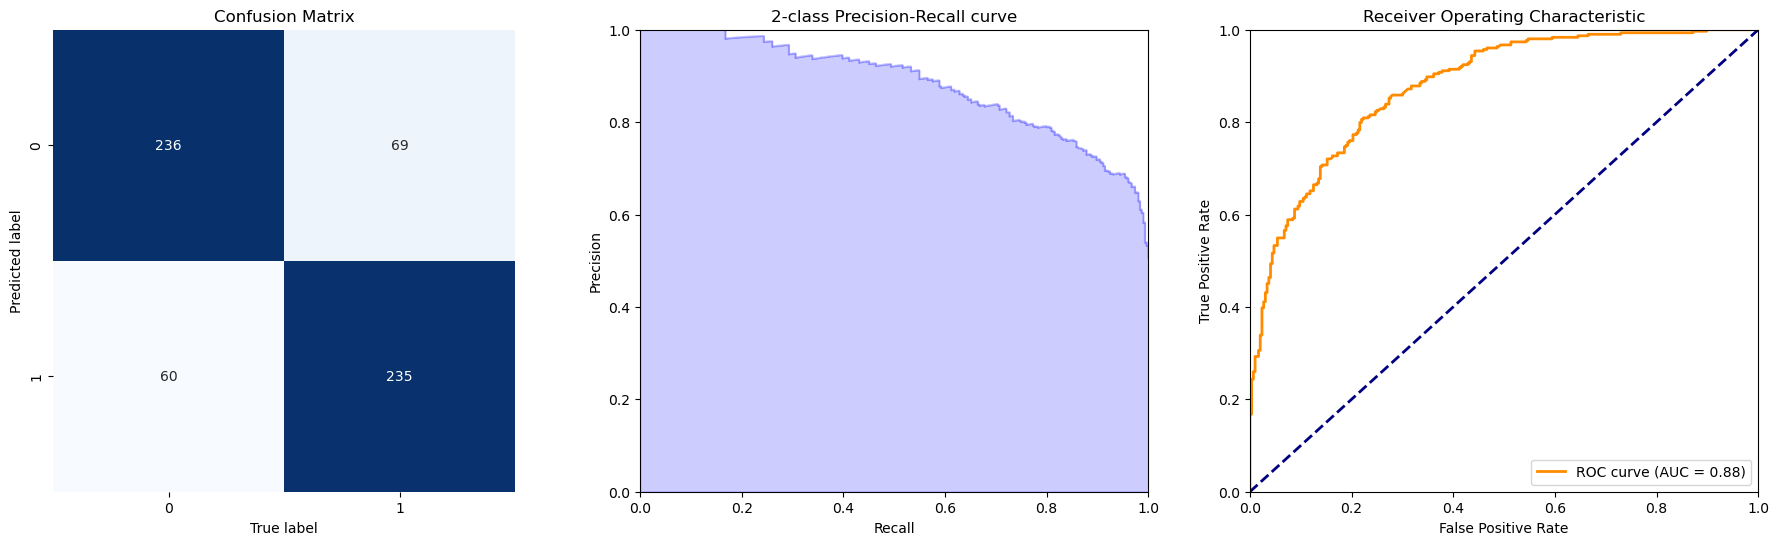

**********
* TF-IDX *
**********
Accuracy : 0.7833 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7919 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7763 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8838                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


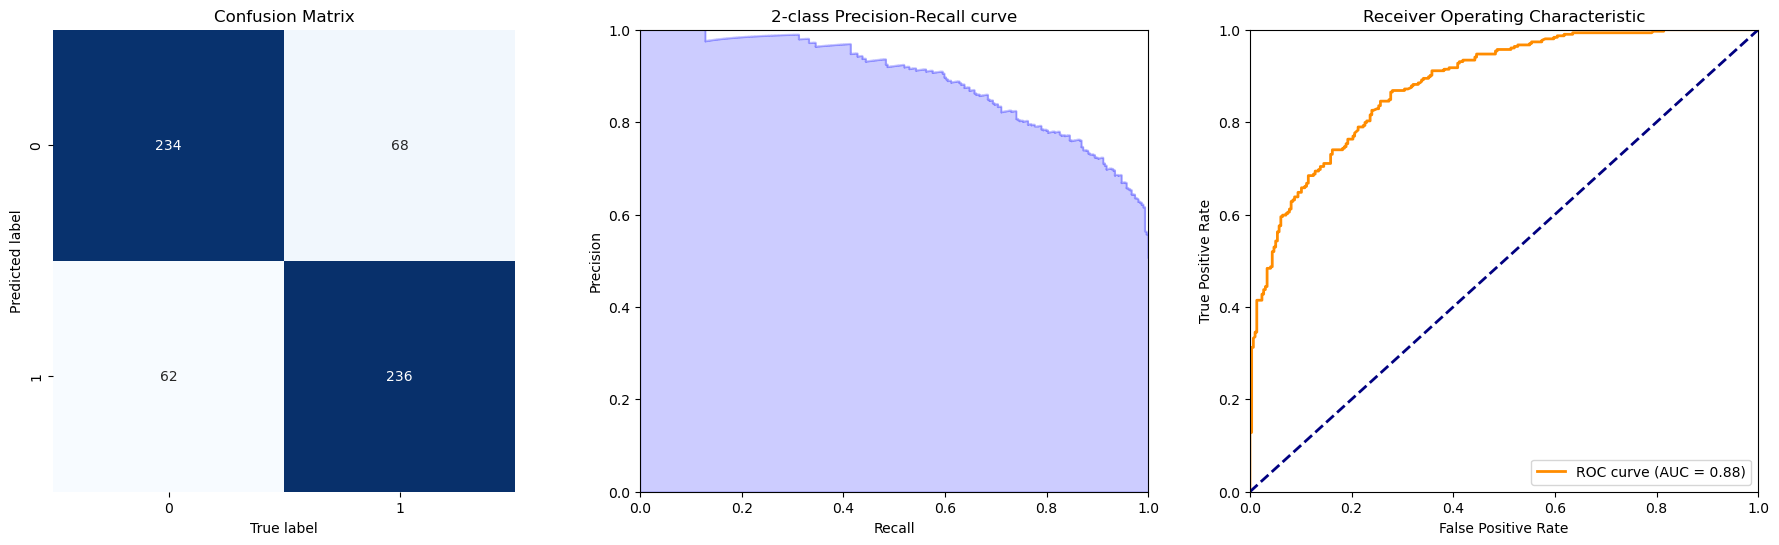

In [286]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    # create a matrix of word counts from the text
    # use TF-IDF
    counts = m
    # do the actual counting
    A = counts.fit_transform(X_train)

    # create a classifier using SVC
    classifier = SVC(kernel='linear', probability=True)

    # train the classifier with the training data
    classifier.fit(A, y_train)

    # do the transformation for the test data
    # NOTE: use `transform()` instead of `fit_transform()`
    B = counts.transform(X_test)

    # make predictions based on the test data
    predictions = classifier.predict(B)

    # store probabilities of predictions being 1
    probabilities = classifier.predict_proba(B)[:, 1]

    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions, probabilities)
    # keep the results
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}

In [287]:
# print results dataframe
results

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.785000,0.796610,0.773026,0.878284
1,TF-IDX,0.783333,0.791946,0.776316,0.883785




---



---



> > > > > > > > > © 2023 Institute of Data


---



---



